In [1]:
import numpy as np
import xarray as xr
from tqdm import tqdm
from xcape.core import calc_cape
import os

In [2]:
ds_tas = xr.open_dataset("/scratch/nf33/hk25_LSP/UK/MC/tas_3hourly.nc")
ta_surf = ds_tas["tas"].stack(ngrid=('latitude','longitude')).values.flatten()-273.15
ds_tdews = xr.open_dataset("/scratch/nf33/hk25_LSP/UK/MC/tdews_3hourly.nc")
tdew_surf = ds_tdews["tdews"].stack(ngrid=('latitude','longitude')).values.flatten()-273.15

In [3]:
ds_ta = xr.open_dataset("/scratch/nf33/hk25_LSP/UK/MC/ta_3hourly.nc")
ds_tdew = xr.open_dataset("/scratch/nf33/hk25_LSP/UK/MC/tdew_3hourly.nc")


In [4]:
ta_da = ds_ta["ta"].stack(ngrid=('time','latitude','longitude')).isel(pressure=slice(None, None, -1)).transpose('ngrid','pressure')-273.15
tdew_da = ds_tdew["tdew"].stack(ngrid=('time','latitude','longitude')).isel(pressure=slice(None, None, -1)).transpose('ngrid','pressure')-273.15

In [5]:
ta_val = ta_da.load().values
td_val = tdew_da.load().values
psurf = np.zeros(ta_val.shape[0])
psurf[:] = 1000

In [6]:
plvl = ds_ta.pressure.isel(pressure=slice(None, None, -1)).values.astype(float)

In [7]:
plvl

array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  800.,  750.,
        700.,  600.,  500.,  400.,  300.,  250.,  200.,  150.,  100.])

In [8]:
ta_val.shape, td_val.shape, ta_surf.shape

((1881798, 18), (1881798, 18), (1881798,))

In [ ]:
%%time
cape, cin, mulev, zmulev = calc_cape(plvl, ta_val, td_val, 
                                         psurf,ta_surf, 
                                         tdew_surf,
                                         source ='most-unstable', vertical_lev="pressure")

In [10]:
cape_2d = cape.reshape(ds_ta.time.shape[0],ds_ta.latitude.shape[0],ds_ta.longitude.shape[0])
cin_2d = cin.reshape(ds_ta.time.shape[0],ds_tdew.latitude.shape[0],ds_tdew.longitude.shape[0])

In [11]:
cape_2d.shape

(1696, 2, 2)

In [14]:
out = xr.Dataset(
        {
            "cape": (("time","latitude","longitude"), cape_2d),
            "cin":  (("time","latitude","longitude"), cin_2d),
        },
        coords={
            "latitude": ds_ta.latitude,
            "longitude": ds_ta.longitude,
            "time":      ds_ta.time,
        },
    )
out.to_netcdf(f"/scratch/nf33/hk25_LSP/UK/MC/cape_cin_3hourly.nc")

In [15]:
ds_era5_cape = xr.open_dataset("/scratch/nf33/dl6968/prep_hk25/environment/cape_hackathon_ts.nc")

In [16]:
ds_era5_cin = xr.open_dataset("/scratch/nf33/dl6968/prep_hk25/environment/cin_hackathon_ts.nc")

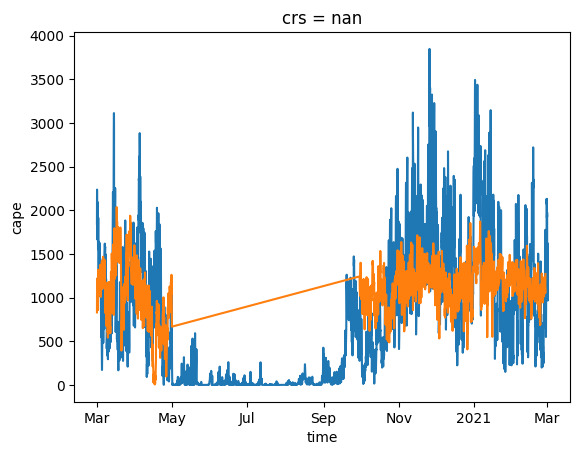

In [17]:
ds_era5_cape["cape"].plot()
out["cape"].mean(dim=("latitude","longitude")).plot()

In [18]:
era5_cape_3h = ds_era5_cape["cape"].sel(time = out.time)
era5_cin_3h = ds_era5_cin["cin"].sel(time = out.time)

In [24]:
import matplotlib.pyplot as plt

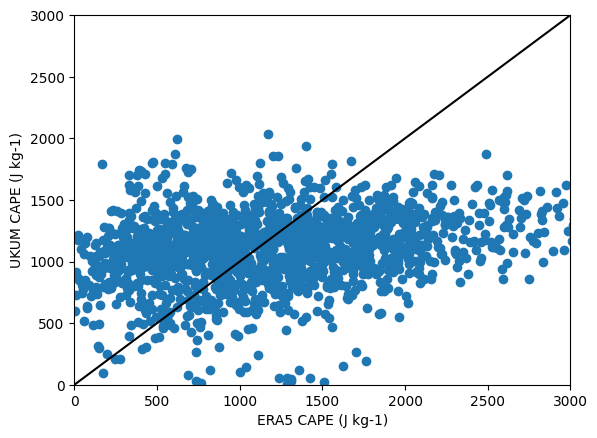

In [27]:
plt.figure()
plt.scatter(era5_cape_3h,out["cape"].mean(dim=("latitude","longitude")))
plt.xlabel("ERA5 CAPE (J kg-1)")
plt.ylabel("UKUM CAPE (J kg-1)")
plt.xlim([0,3000])
plt.ylim([0,3000])
plt.plot(np.arange(0,61000,20), np.arange(0,61000,20), color="k")

Text(0, 0.5, 'UKUM CIN (J kg-1)')

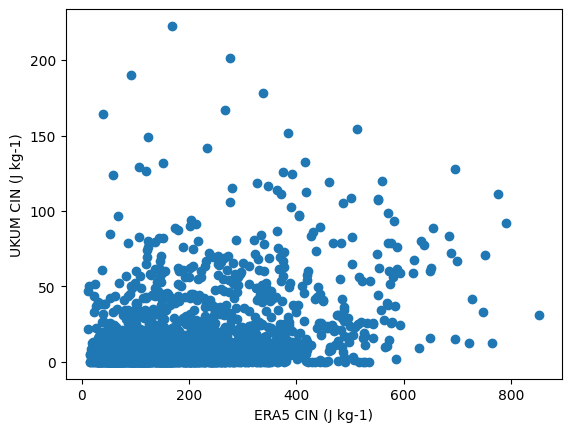

In [26]:
plt.figure()
plt.scatter(era5_cin_3h,out["cin"].mean(dim=("latitude","longitude")))
plt.xlabel("ERA5 CIN (J kg-1)")
plt.ylabel("UKUM CIN (J kg-1)")